# Problem statement

Given the recent history of a user's interactions with previous email campaigns, can you predict the success of the next one? This is a common business problem, but one that it is usually hard to find real, publicly accessible datasets for.

https://www.kaggle.com/c/student-shopee-code-league-marketing-analytics/overview

## Background Information

The aim of this project is to build a model that can predict whether a user opens the emails sent by Shopee.

Sending emails is one of the marketing channels Shopee uses to reach out to our users. Being able to predict whether a user opens an email allows Shopee to forecast and evaluate the performance of future marketing campaigns before launch. This is because when a user opens an email, the probability of the user knowing the campaign increases and this in turn increases the probability of the user making a checkout during the campaign period. Therefore, with the predicted open rates, Shopee can better develop, strategize and implement future marketing campaigns.

## Task

We provide you with data related to marketing emails (Electronic Direct Mail) that were sent to Shopee users over a certain period. It contains information about

User-specific information\
Email nature\
Users’ engagement on the platform\
User’s reaction to the email, including whether users opened the email\
Based on the data provided, you must predict whether each user will open an email sent to him/her.

# About the data

**[train/test].csv**

country_code: An integer code for the country where the user lives.\
grass_date: The date when the email was sent.\
user_id: the unique identifier of each user\
subject_line_length: the number of characters in the subject of the email\
last_[open/login/checkout]_day: the number of days since the previous email open, user login, or checkout.\
open_count_last_[10/30/60]_days: the total number of email opens in the last N days.\
login_count_last_[10/30/60]_days: the total number of user logins in the last N days.\
checkout_count_last_[10/30/60]_days: the total number of checkouts by the user in the last N days.\
open_flag: the target variable. Whether or not the email was opened.\
row_id:\

**users.csv**

user_id: the unique identifier of each user\
attr_[1/2/3]: general user attributes. Attr_1 and attr_2 are boolean, attrib_3 can be integer [1,2,3,4].\
age: The user's reported age.\
domain: The user's top-level email domain. Less common domains are bundled together under the label 'other'.\


# Library

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import IsolationForest           # outlier analysis

In [2]:
pd.options.display.max_columns = None #view all columns

# Load data

In [3]:
ls dataset/

sample_submission_0_1.csv  train.csv
test.csv                   users.csv


## Data cleaning

In [4]:
# get df
users = pd.read_csv('dataset/users.csv')                  # load user data
df = pd.read_csv('dataset/train.csv'                      # load training data
                ).drop(['row_id'], axis=1)                # drop row ID
df = pd.merge(df, users, on='user_id')                    # merge user and training data

# reformat df
df = df.assign(grass_date = 
    pd.to_datetime(                                       # clean grass_date
        df['grass_date'].str.replace('00:00:00\+08:00','')),
    last_open_day = pd.to_numeric(
        np.where(                                         # replace 0 in last_open_days
            df['last_open_day'] == 'Never open',          
                 0, df['last_open_day'])),
    last_login_day = pd.to_numeric(
        np.where(                                         # replace 0 in last_login_day
            df['last_login_day'] == 'Never login',        
                 0, df['last_login_day'])),
    last_checkout_day = pd.to_numeric(
        np.where(                                         # replace 0 in last_checkout_day
            df['last_checkout_day'] == 'Never checkout',  
                 0, df['last_checkout_day'])),
    open_flag = df['open_flag'].astype('bool')           # convert open_flag to bool
              )

# OHE df
df = pd.get_dummies(data = df,                            
                    columns=['domain',                     # OHE domain
                             'attr_1',                     # OHE user attr 1
                             'attr_2',                     # OHE user attr 2
                             'country_code'                # OHE country code
                            ])

# format df
df = pd.concat([df[['user_id']],                           # put user id as first col
                df.drop(['open_flag',
                         'user_id'], axis=1),              # reorder outcome to last col
                df[['open_flag']]], axis=1)

# data cleaning
# df = df.assign(
#     age = np.where(                                     # min legal age and life expectancy
#         (np.abs(df['age'])>=18) & (np.abs(df['age'])<=84),                 
#         np.abs(df['age']),np.nan)                       # handle negative age
# )

## Data inspection

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      73539 non-null  int64         
 1   grass_date                   73539 non-null  datetime64[ns]
 2   subject_line_length          73539 non-null  int64         
 3   last_open_day                73539 non-null  int64         
 4   last_login_day               73539 non-null  int64         
 5   last_checkout_day            73539 non-null  int64         
 6   open_count_last_10_days      73539 non-null  int64         
 7   open_count_last_30_days      73539 non-null  int64         
 8   open_count_last_60_days      73539 non-null  int64         
 9   login_count_last_10_days     73539 non-null  int64         
 10  login_count_last_30_days     73539 non-null  int64         
 11  login_count_last_60_days     73539 non-nu

,user_id,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_3,age,domain_@163.com,domain_@gmail.com,domain_@hotmail.com,domain_@icloud.com,domain_@live.com,domain_@outlook.com,domain_@qq.com,domain_@rocketmail.com,domain_@yahoo.com,domain_@ymail.com,domain_other,attr_1_0.0,attr_1_1.0,attr_2_0.0,attr_2_1.0,country_code_1,country_code_2,country_code_3,country_code_4,country_code_5,country_code_6,country_code_7,open_flag
0,43,2019-07-16,44,19,6,18,0,2,4,12,43,99,0,5,10,2.0,47.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,False
1,102,2019-07-16,44,9,4,8,2,9,17,18,48,90,1,1,4,2.0,25.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,True
2,177,2019-07-16,49,14,5,5,0,4,12,24,69,119,5,19,27,0.0,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,False
3,184,2019-07-16,49,49,9,53,0,0,1,9,23,69,1,3,6,2.0,24.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,False
4,221,2019-07-16,49,227,6,221,0,0,0,2,5,5,0,0,0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,False


# Explore data

We want to know what are the factors affecting the users flagging the email

## Correlation plot

Looking at correlation plot, we know that to increase likelihood of open email:

1. Shorter ```subject_line_length```
2. a more recent ```last_open_day```
3. open more email in past 10/30/60 days ```open_count_last_xx_days```
4. older ```age```
5. lesser ```google.com``` email and more ```hotmail``` and ```other``` emails
6. lesser people from ```country_code_1``` and more people from ```country_code_4```

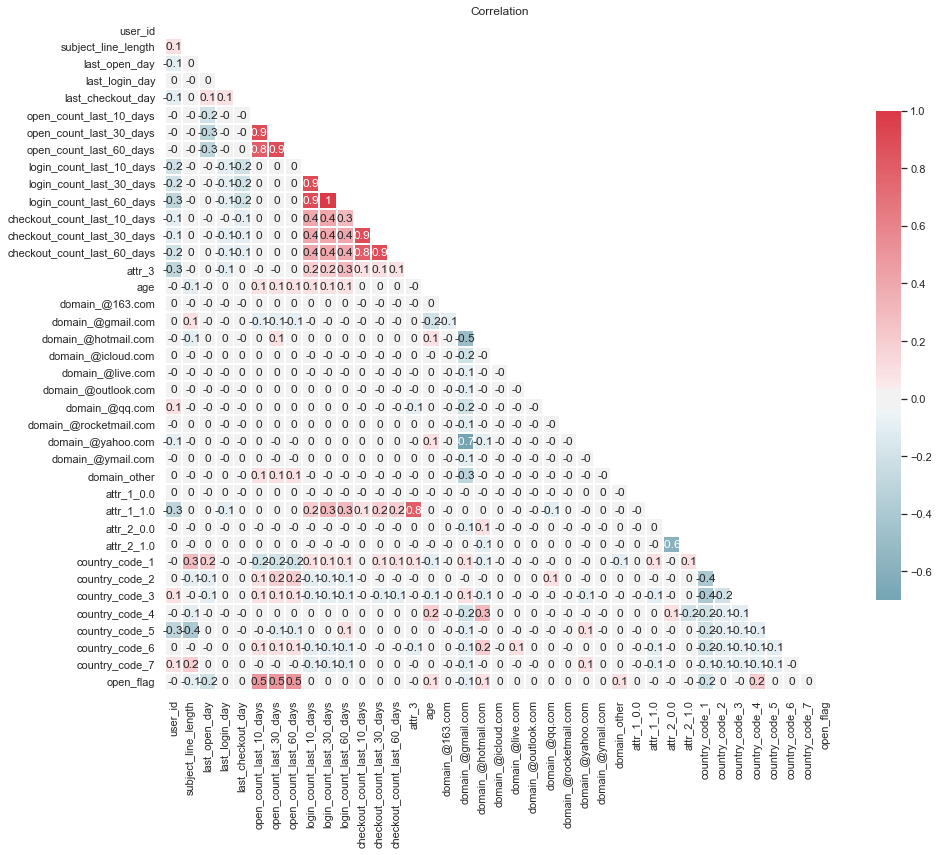

In [6]:
corr = df.corr().apply(lambda x: round(x,1))
figure, ax = plt.subplots(figsize=[15,15]);
cmap = sns.diverging_palette(220, 10, as_cmap=True);
mask = np.triu(np.ones_like(corr, dtype=np.bool));
sns.heatmap(corr, cmap=cmap, mask=mask, center=0, annot=True,
                square=True, linewidths=1, cbar_kws={'shrink':.6});
plt.title('Correlation'), ax.set_facecolor('white');

## A look at age

Since age is the only feature with missing values, let's see how should we impute it

In [7]:
print('non missing values occupy {:.2f}% of data'.format(df['age'].notna().mean()*100))

non missing values occupy 61.66% of data


In [8]:
tmp = df.loc[df['age'].notna(),'age'] # only contains non missing age values

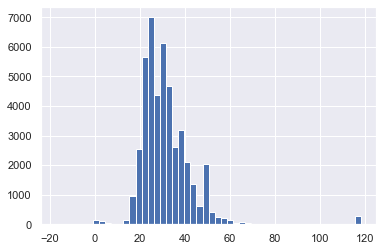

In [9]:
plt.hist(tmp,bins=50);

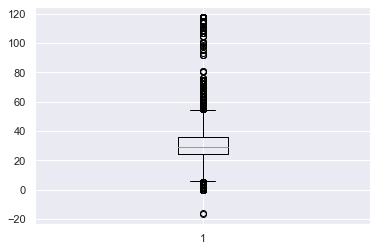

In [10]:
plt.boxplot(tmp);

In [11]:
df['age'].describe()

count    45347.000000
mean        31.445564
std         11.797405
min        -17.000000
25%         24.000000
50%         29.000000
75%         36.000000
max        118.000000
Name: age, dtype: float64

We notice that there are some anomalies in our age data

In [12]:
(df['age']>90).sum()

325

## Bootstrap simulation to get mean age

From our bootstrap simulation, we know that the mean age is about the mean age of the data

In [13]:
def simulate_age(n):
    sample_mean = df[['age']].sample(n=500).mean()
    return sample_mean[0]

In [14]:
simulated_age = list(map(simulate_age, np.arange(1,1000)))

NormaltestResult(statistic=0.08709404003041918, pvalue=0.9573875366560799)
DescribeResult(nobs=999, minmax=(29.05723905723906, 33.81518151815182), mean=31.44513769342576, variance=0.41171137623330206, skewness=0.021601005445912994, kurtosis=-0.030993596327177464)


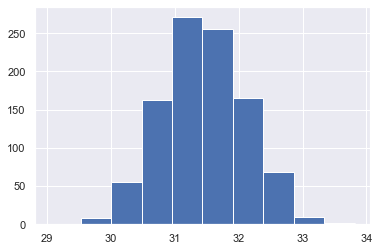

In [15]:
plt.hist(simulated_age);
print(stats.normaltest(simulated_age))
print(stats.describe(simulated_age))

## Outlier analysis using Isolation Forest

Isolation forest identify age groups which I think is possible to have, etc from 40 to 80.

Let's just identify the age that's older than 84 and younger than 18 as outlier ages.\
84 is the life expectancy of Singapore (one of the oldest in Asia, where Shopee operates) and 18 is the youngest legal age to register an account with Shopee, kids younger than 18 will have the tendency to fake their age but less likely with adults.

Shopee min age: https://mall.shopee.sg/legaldoc/termsOfService/

In [16]:
iso_forest = IsolationForest(n_jobs=-1, random_state=0,
                            n_estimators = 500, max_features=0.2)

In [17]:
iso_forest.fit(tmp.values.reshape(-1,1))

IsolationForest(max_features=0.2, n_estimators=500, n_jobs=-1, random_state=0)

In [18]:
outlier_index = iso_forest.predict(tmp.values.reshape(-1,1))

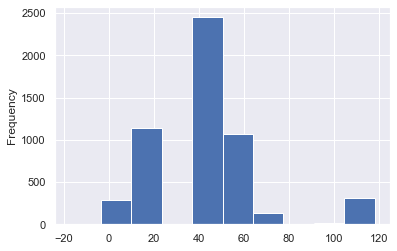

In [19]:
tmp[np.where(outlier_index == 1, False, True)].plot.hist()

# Remarks

Most of the features seems pretty clean, only minor adjustments are needed to correct the dtypes.\
Age is a problematic feature, the mean age still seems to be correct but Isolation Forest is unable to detect the outliers that we want. Instead, we apply common sense to remove the outliers. This might not accurate but we will explore more later.